In [ ]:
!pip install visdom
!pip install nibabel
!pip install h5py
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sha256=36259079effa1e7f6cc631988929b68ed0b1ded02c109f82c12e612f9215b46e
  Stored in directory: /root/.cache/pip/wheels/fa/a4/bb/2be445c295d88a74f9c0a4232f04860ca489a5c7c57eb959d9
Successfully built visdom
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.0 MB/s eta 0:00:00


In [ ]:
#import all libraries
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import os
import sys
import pickle
import time
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd
from torch.autograd import Variable
from torchvision import transforms
from tensorboardX import SummaryWriter
import math
from sklearn import metrics
import matplotlib.pyplot as plt

# Mount Google Drive to access your data



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# path to the folder on Google drive where we uploaded the MRNet dataset to
mrnet_directory = './gdrive/MyDrive/MRNet-v1.0/'

# Exploring dataset

*   The dataset consists of 1,250 knee MRIs with image level labels.
*   The training data consists of 1,130 MRIs and the validation data consists of 120 MRIs.
*   They are labelled as abnormal, having an acl tear and/or meniscus tear.
*   Each MRI exam includes data from the axial, coronal and sagittal plane.
*   Axial is a Proton-Density series, coronal is a T1-weighted series and sagittal is T2-weighted series.

## Visualization of a few slices in Sagittal an Coronal planes

Sagittal volume shape: (36, 256, 256)
Coronal volume shape: (36, 256, 256)


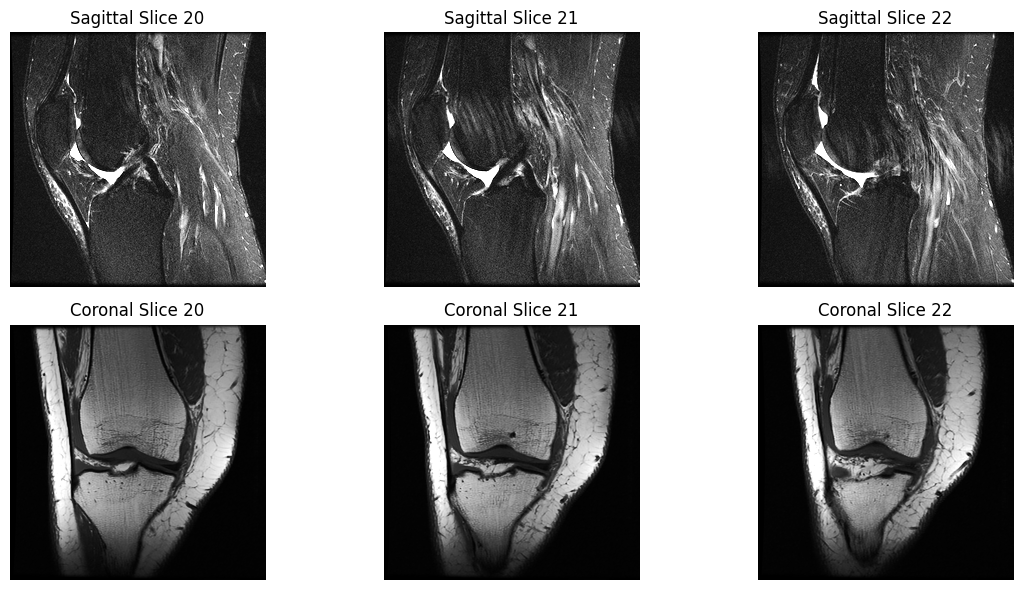

In [ ]:
# patient ID
patient_id = '0000'

# file paths to Sagittal an Coronal files
sagittal_path = os.path.join(mrnet_directory, 'train/sagittal', f'{patient_id}.npy')
coronal_path = os.path.join(mrnet_directory, 'train/coronal', f'{patient_id}.npy')

# load MRI volumes
sagittal_volume = np.load(sagittal_path)  # shape: [slices, height, width]
coronal_volume = np.load(coronal_path)    # shape: [slices, height, width]

print(f"Sagittal volume shape: {sagittal_volume.shape}")
print(f"Coronal volume shape: {coronal_volume.shape}")

# slice indices to visualize
slice_indices = range(20, 23)

# plot sagittal and coronal slices, 3 of each
plt.figure(figsize=(12, 6))
for i, idx in enumerate(slice_indices):
    # sagittal
    plt.subplot(2, 3, i + 1)
    plt.imshow(sagittal_volume[idx], cmap='gray')
    plt.title(f"Sagittal Slice {idx}")
    plt.axis('off')

    # coronal
    plt.subplot(2, 3, i + 4)
    plt.imshow(coronal_volume[idx], cmap='gray')
    plt.title(f"Coronal Slice {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Split the dataset into Train - Validate - Test.

We will use the original Validation set as a set for choosing model architecture and tune hyper-parameters. We split the original Train set into 80-20 proportion into Train and Test sets. We did a **stratified** split which preserves proprortion of abnormal examples in the original Train set.

Note, that we ran the below code to split data **strictly once**. We wrote the IDs of the split Train-Test examples in CSV files on the Google drive, and read those CSVs files an all furthers runs. This allowed us to always use the same Train and Validation sets during the training and tuning phase.

We held out the Test set until the very last step, and only used the Test set once - for a final test of the model, after we have chosen the best model and finished hyper-paramaters tuning.

Our test set was truly unseen by the model until the final evaluation, ensuring an unbiased assessment of its performance.


In [ ]:
# only had the split_train_test = True once, to hold out the Test set
# keep split_train_test = False
split_train_test = False

if (split_train_test):

    from sklearn.model_selection import train_test_split

    tasks = ['abnormal', 'acl', 'meniscus']

    for task in tasks:
        print(f"\nProcessing: {task}")

        # original CSV
        original_csv = os.path.join(mrnet_directory, f'train-{task}.csv')
        df = pd.read_csv(original_csv, header=None, names=['id', 'label'])

        # back up the original CSV
        backup_csv = os.path.join(mrnet_directory, f'train-{task}-original.csv')
        if not os.path.exists(backup_csv):
            os.rename(original_csv, backup_csv)
            print(f"Renamed {original_csv} to {backup_csv}")

        # original label counts
        print("Original label distribution:")
        print(df['label'].value_counts())

        # stratified train-test split
        train_df, test_df = train_test_split(
            df, test_size=0.2, stratify=df['label'], random_state=42
        )

        # save new sets of IDs to CSVs
        train_df.to_csv(os.path.join(mrnet_directory, f'train-{task}.csv'), index=False, header=False)

        test_df.to_csv(os.path.join(mrnet_directory, f'test-{task}.csv'), index=False, header=False)

        # new label distribution
        print("Training label distribution:")
        print(train_df['label'].value_counts())
        print("Test label distribution:")
        print(test_df['label'].value_counts())

        print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")


Screenshots of the output when we ran the Train-Test split, when we started to work on the assignment:

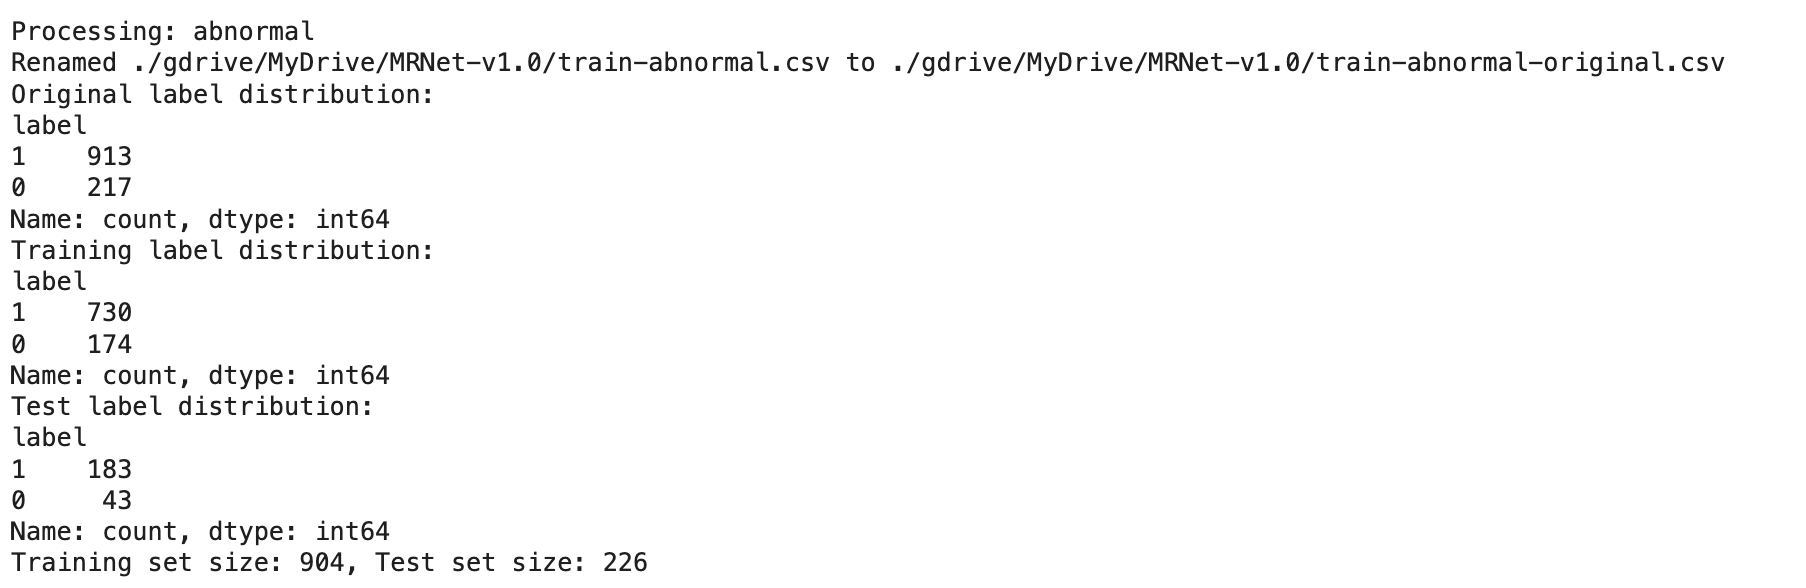

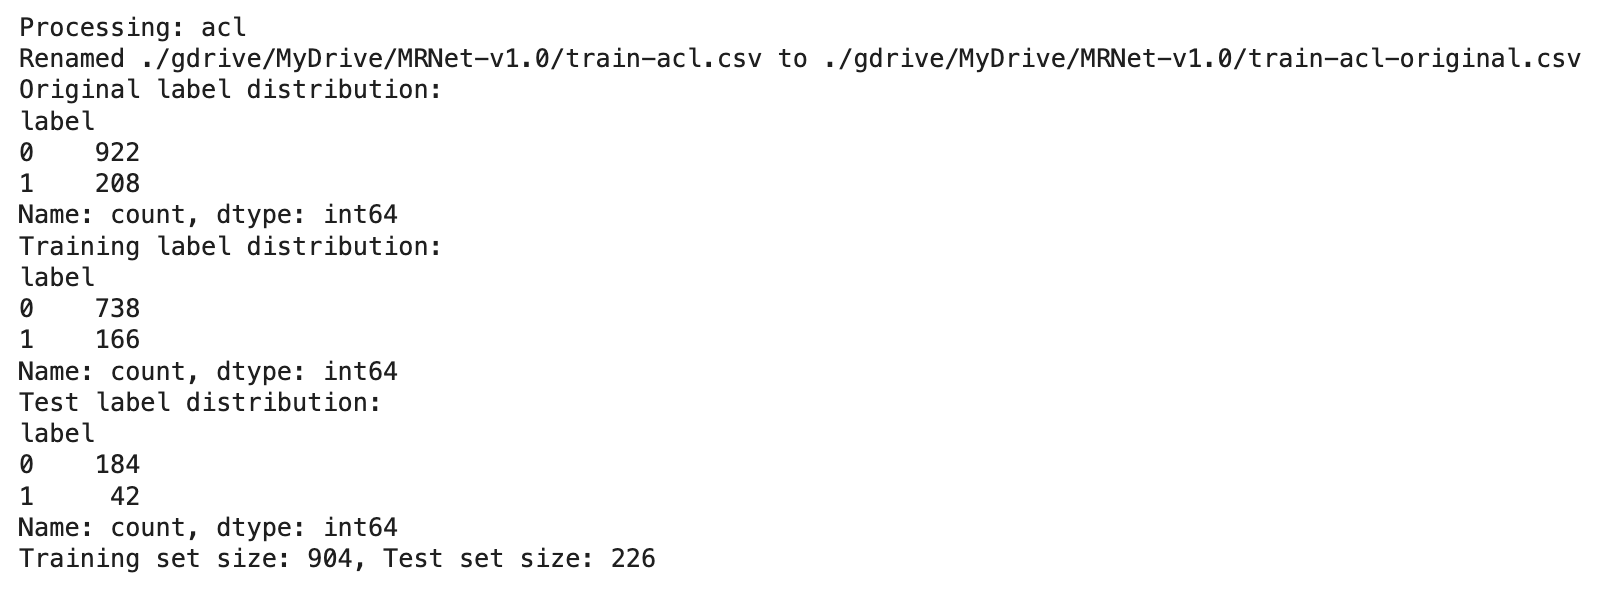

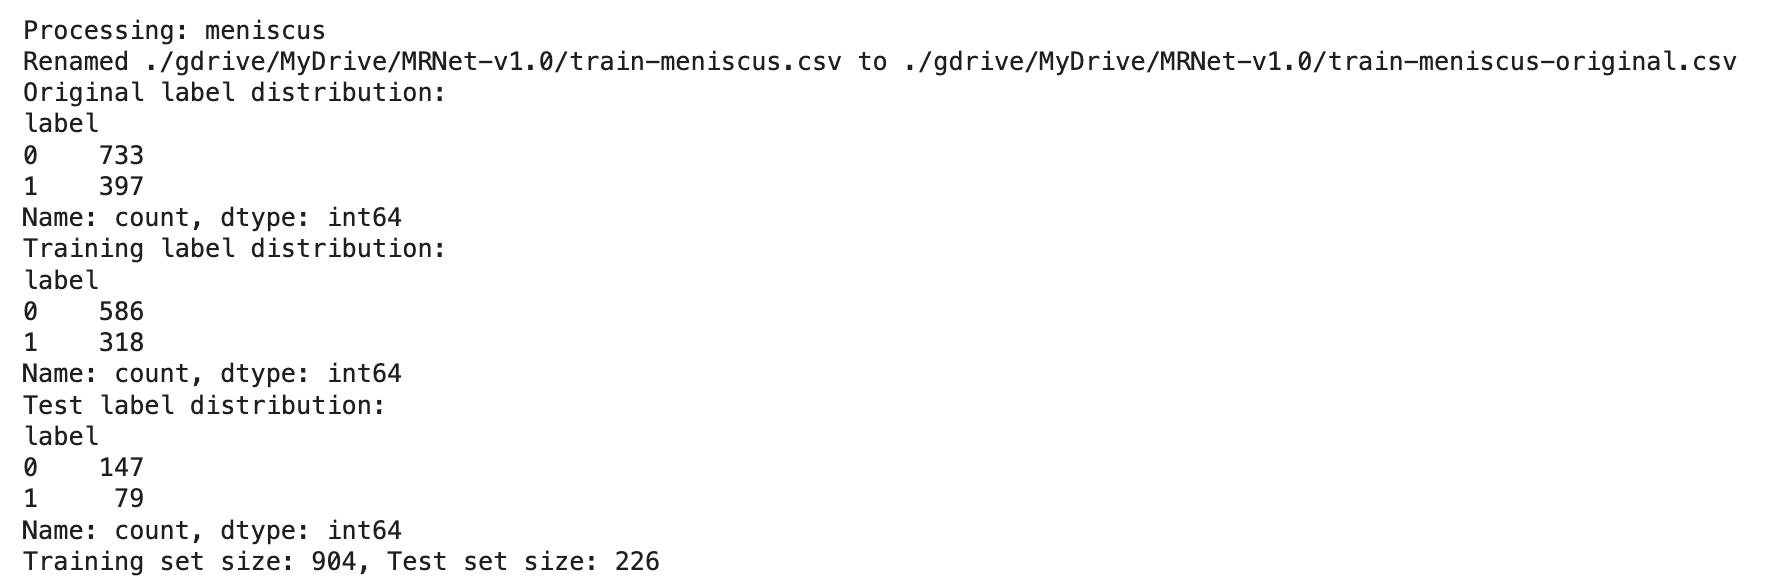

# Definition of the model

We define our model in the class `TwoPlanesNet`. The `init` function initialises the architecture of the model - see detailed comments in the function.

The line of code `base_model = models.efficientnet_b2` sets our backbone model to the EfficientNet-B2 model. The line `weights = EfficientNet_B2_Weights.DEFAULT` initialises the weights of the model with the weights for the Efficientnet-B2 model pre-trained on the ImageNet dataset. This is a transfer learning technique which speeds up tarining.

EfficientNet-V2 model in pytorch documentation: https://docs.pytorch.org/vision/main/models/efficientnetv2.html

We created a two-branched architecture, one branch for sagittal and one branch for coronal plane. We define the `make_branch` method indside of the `init` method, which initialises each branch's backbone and replaces the first convolutional layer with a new convolutional layer, with all the same parameters except that the number of input channels gets reduced from 3 to 1  - this is our optimization for grayscale images.


In the `init` method, we also initialize Spatial Attention moldues for each branch, e.g., for sagittal: `self.attn_sag = SpatialAttentionModule()`

We also initialise a plane-specific classifiers and a *final,  fused* classifier that takes as input concatenated logits from the palne-specific classifiers.

After the model is initialised, the `forward` function is called iteratively throughout the training process. In the `forward` method, we extract features from the EfficientNet backbone, apply the spatial attention to the extracted features, followed by global average pooling. Then we aggregate features across slices (temporal agregation) for each plane, pass them through separate, plane-specific classifiers, and concatenate the classifiers output. The last step in the `forward` method - we **fuse** the sagittal and coronal predictions using a linear layer, which produces the final output logit.


In [ ]:
# import weights for pre-trained EfficientNet-B2 model (pre-trained on ImageNet)
from torchvision.models.efficientnet import EfficientNet_B2_Weights

# the original EfficientNet-B2 model, which we use as a backbone, but we add our customizations later
models.efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Declare a **Spatial Attention Module** class, which we then use when we define the model class:

In [ ]:
class SpatialAttentionModule(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()

        # padding (preserve spatial dimensions after conv.)
        padding = kernel_size // 2 # (kernel size - 1 )/2 = (7 - 1 )/ 2 = 2

        # convolutional layer with input in the form of 2 channels:
        #   1st channel is avg-pooled map
        #   2nd channel is max-pooled map
        # output is attention map, 1-channeled
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)

        # scale attention map to [0, 1]
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): # [B, C, H, W]

        # max-pool and avg-pool across channel dimension
        avg_out = torch.mean(x, dim=1, keepdim=True) # [B, 1, H, W]
        max_out, _ = torch.max(x, dim=1, keepdim=True) # [B, 1, H, W]

        # concat, becomes [B, 2, H, W]
        x = torch.cat([avg_out, max_out], dim=1)

        # pass through conv layer, becomes [B, 1, H, W]
        x = self.conv(x)

        # scale final attention weights, output is [B, 1, H, W]
        return self.sigmoid(x)

Define the class for the model which has two branches, one per anatomical plane, each is based on the EfficientNet-B2 backbone:

In [ ]:
class TwoPlanesNet(nn.Module):
    def __init__(self):
        super().__init__()

        # EfficientNet-B2 as the base model (backbone)
        base_model = models.efficientnet_b2
        # with pre-trained ImageNet weights
        weights = EfficientNet_B2_Weights.DEFAULT

        # helper-method, with code which is repeated for coronal and sagittal planes
        def make_branch():

            # load pre-trained EfficientNet-B2
            model = base_model(weights=weights)

            # first conv2D layer which expects 3-channel input for RGB
            conv1 = model.features[0][0]

            # prepare a new conv layer with all same params as the original conv layer, but 1 channel instead of 3, for grayscale input
            new_conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=conv1.out_channels,
                kernel_size=conv1.kernel_size,
                stride=conv1.stride,
                padding=conv1.padding,
                bias=conv1.bias is not None
            )

            # init new conv. layer with average pre-trained RGB weights to use with grayscale
            with torch.no_grad():
                new_conv1.weight[:] = conv1.weight.mean(dim=1, keepdim=True)
                if conv1.bias is not None:
                    new_conv1.bias[:] = conv1.bias

            # replace the original conv layer with the new grayscale layer
            model.features[0][0] = new_conv1

            # returns feature extractor, global avg pooling layer, and final feature dimension (number of features)
            return model.features, model.avgpool, model.classifier[1].in_features

        # create each branch separately
        self.sag_features, self.sag_pool, sag_feat_dim = make_branch()
        self.cor_features, self.cor_pool, cor_feat_dim = make_branch()

        # init Spatial attention modules for both branches
        self.attn_sag = SpatialAttentionModule()
        self.attn_cor = SpatialAttentionModule()

        # plane-specific classifiers, each outputs 1 logit
        # dropout 30% of features
        self.sag_classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(sag_feat_dim, 1)
        )
        self.cor_classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(cor_feat_dim, 1)
        )

        # final fusion classifier
        # takes in concatenated output of the 2 plane-specifc classifiers
        # makes the final prediction, as a single logit
        self.fusion_classifier = nn.Linear(2, 1)

    def forward(self, sag_input, cor_input):  # both shapes are: [B, S, 1, H, W]

        # get dimensions, we use same sizes for both planes
        B, S, C, H, W = sag_input.shape

        # flatten slice dimension into batch dimension
        sag_input = sag_input.view(B * S, C, H, W)
        cor_input = cor_input.view(B * S, C, H, W)

        # extract features from each slice from EfficientNet
        sag_features = self.sag_features(sag_input)
        cor_features = self.cor_features(cor_input)

        # apply spatial attention
        sag_features = sag_features * self.attn_sag(sag_features)
        cor_features = cor_features * self.attn_cor(cor_features)

        # global average pooling
        # each slice becomes a vector
        sag_pooled = self.sag_pool(sag_features) # output [B*S, C, 1, 1]
        cor_pooled = self.cor_pool(cor_features) # output [B*S, C, 1, 1]

        # transform to the original batch shape
        sag_pooled = sag_pooled.view(B, S, -1) # output [B, S, C]
        cor_pooled = cor_pooled.view(B, S, -1) # output [B, S, C]

        # aggregate across slices, temporal
        sag_agg_features = sag_pooled.mean(dim=1) # output [B, C]
        cor_agg_features = cor_pooled.mean(dim=1) # output [B, C]

        # make plane-specific predictions, outputs [B, 1] for each plane
        sag_logit = self.sag_classifier(sag_agg_features)
        cor_logit = self.cor_classifier(cor_agg_features)

        # concat sagittal and coronal logits, becomes [B, 2]
        output = torch.cat([sag_logit, cor_logit], dim=1)

        # final prediction, a single logit
        output = self.fusion_classifier(output)

        return output

In [ ]:
# view the complete model architecture
mod = TwoPlanesNet()
mod

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 86.2MB/s]


TwoPlanesNet(
  (sag_features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

#Create Dataloader
The 'init' function initialises the dataloader. This class is responsible for loading the datasets. It takes the 'root_dir', 'task', 'plane', 'train', 'transform' and 'median_slices' as input parameters.



*   root_dir - the directory to where the data is stored.
*   task - whether the model is being trained to detect acl tears, meniscus tears or abnormalities. Possible values are 'acl', 'meniscus' or 'abnormal'.
*   plane - whether the model is being trained on axial, coronal or sagittal data. Possible values are 'axial', 'coronal' or 'sagittal'.
*   split - which dataset to load, possible values are 'train', 'test', 'valid'.
*   transform - a compose function for performing transformations to the images.
*   median_slices - median number of slices in the plane, required to do a crop/padding  


The init function creates 1) a list of paths to each MRI, 2) a corresponding list of labels that are either ones or zeros


---



The __len__ function returns the length of the dataset.


---
The __getitem__ function is iteratively called throughout the training process, also when running the final test. It takes an index as a input parameter. It loads the MRI at the given index from the list of paths defined in the init function. It also returns the label for the MRI at that index.



In [ ]:
from PIL import Image

class Dataset(data.Dataset):
    def __init__(self, root_dir, task, plane, split='train', transform=None, median_slices = 1):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.split = split # can be 'train', 'valid', or 'test'
        self.transform = transform
        self.median_slices = median_slices

        # folder logic based on the 'split' value
        if split == 'valid':
            self.folder_path = os.path.join(self.root_dir, f"valid/{plane}/")
        else:
            # both 'train' or 'test' images ar ein the 'train/' folder
            # when we split the data, we created separate CSV files with test and train examples, but the images themselves remain in the original folder
            self.folder_path = os.path.join(self.root_dir, f"train/{plane}/")

        csv_filename = f"{split}-{task}.csv"
        csv_path = os.path.join(self.root_dir, csv_filename)

        self.records = pd.read_csv(csv_path, header=None, names=['id', 'label'])

        # pad ID to 4 digits
        self.records['id'] = self.records['id'].astype(str).str.zfill(4)

        self.paths = [os.path.join(self.folder_path, f"{filename}.npy") for filename in self.records['id']]

        self.labels = self.records['label'].tolist()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):

        # load MRI as [slices, 256, 256]
        array = np.load(self.paths[index])

        # get label of MRI
        label = self.labels[index]

        # convert type from numpy to torch
        label = torch.FloatTensor([label])

        # crop or pad slices, so that each MRI has a median mumber of slices
        # it is required to be able to stack them in tensor when we do batch processing
        current_slices = array.shape[0]
        if current_slices < self.median_slices:
            # padding, CNN will treat it as a background
            pad = np.zeros((self.median_slices - current_slices, 256, 256))
            array = np.concatenate((array, pad), axis=0)
        elif current_slices > self.median_slices:
            # crop excess slices
            array = array[:self.median_slices]

        # if transormation is required
        if self.transform:
            array = torch.stack([
                self.transform(Image.fromarray(slice.astype(np.uint8)))
                for slice in array
            ], dim=0)

        else:
            # manually add channel
            array = array[:, np.newaxis, :, :]
            # only needed in the non-transform case
            array = torch.FloatTensor(array)

        return array, label

Dataset that fuses slices fom the two planes:

In [ ]:
class FusedPlanesDataset(torch.utils.data.Dataset):
    def __init__(self, sagittal_dataset, coronal_dataset):

        # ensure both input datasets have the same length
        assert len(sagittal_dataset) == len(coronal_dataset), "ds lengths error"

        self.sagittal_dataset = sagittal_dataset
        self.coronal_dataset = coronal_dataset

    def __len__(self):
        # as we assert the length is the same, return here any plane
        return len(self.sagittal_dataset)

    def __getitem__(self, index):

        # retrieve the sagittal and coronal data at the same index
        sag_data, label1 = self.sagittal_dataset[index]
        cor_data, label2 = self.coronal_dataset[index]

        # ensure both planes have the same label at the same index
        assert torch.equal(label1, label2), f"Label mismatch at index {index}"
        return (sag_data, cor_data), label1

Median Slice and Resolution Analysis per plane.
Batch requires same number of slices across the batch, thus we need to establish the numeber of slices we will have in input tensor based on median in the MRNet train dataset.

In [ ]:
def dataset_stats(paths, plane):
    slice_counts = []
    resolutions = []
    processed_files = 0

    start = time.time()

    # first pass - count total pixels
    total_pixels = 0
    for path in paths:
        try:
            arr = np.load(path)
            total_pixels += arr.size
            slice_counts.append(arr.shape[0])
            resolutions.append(arr.shape[1:])
        except Exception as e:
            print(f"Failed to load {path}: {e}")
            continue

    # preallocate array for pixel intensities
    all_pixels = np.empty(total_pixels, dtype=np.float32)

    # second pass - fill array with pixel intensities
    index = 0
    for path in paths:
        try:
            arr = np.load(path)
            flat = arr.flatten().astype(np.float32)
            all_pixels[index:index + flat.size] = flat
            index += flat.size
            processed_files += 1
        except Exception as e:
            print(f"Exception in 2nd part, in file {path}: {e}")
            continue

    # final stats
    median_slices = int(np.median(slice_counts))
    min_slices = int(np.min(slice_counts))
    max_slices = int(np.max(slice_counts))

    res_set = set(resolutions)

    all_pixels = np.array(all_pixels)
    mean = all_pixels.mean()
    std = all_pixels.std()

    print(f"=== Plane: {plane}")
    print(f" Processed files: {processed_files}")
    print(f" Median slices: {median_slices}")
    print(f" Min slices: {min_slices}")
    print(f" Max slices: {max_slices}")
    print(f" Unique resolutions: {res_set}")
    print(f" Pixel intensities:")
    print(f"   Mean: {mean:.6f}")
    print(f"   Std: {std:.6f}")
    print(f"Completed in {time.time() - start:.2f}s")

# keep this FALSE, unless you need to recalculate the stats
# but we claclualated the stats once, and shouldn't need to do that anymore
calculate_ds_stat = False
if (calculate_ds_stat):

    task = 'acl'
    for plane in ['sagittal','coronal']:

        temp_ds = Dataset(mrnet_directory, task, plane, median_slices=1, split='train')

        dataset_stats(temp_ds.paths, temp_ds.plane)


# do not calc every time, once is enough. Results were obtained:

#=== Plane: sagittal
# Processed files: 904
# Median slices: 30
# Min slices: 17
# Max slices: 51
# Unique resolutions: {(256, 256)}
# Pixel intensities:
#   Mean: 58.887421
#   Std: 48.638046
#Completed in 529.15s
#=== Plane: coronal
# Processed files: 904
# Median slices: 30
# Min slices: 17
# Max slices: 58
# Unique resolutions: {(256, 256)}
# Pixel intensities:
#   Mean: 59.697620
#   Std: 64.183678
#Completed in 515.66s

In [ ]:
# checking data type - to make sure it's uint8, as it matters when we apply ToTensor()

# sagittal
sagittal_path = os.path.join(mrnet_directory, 'train/sagittal/0001.npy')
sag_slice = np.load(sagittal_path)
print(f"[Sagittal] Slice shape: {sag_slice.shape}, Min: {sag_slice.min()}, Max: {sag_slice.max()}, Dtype: {sag_slice.dtype}")

# coronal
coronal_path = os.path.join(mrnet_directory, 'train/coronal/0001.npy')
cor_slice = np.load(coronal_path)
print(f"[Coronal] Slice shape: {cor_slice.shape}, Min: {cor_slice.min()}, Max: {cor_slice.max()}, Dtype: {cor_slice.dtype}")

[Sagittal] Slice shape: (26, 256, 256), Min: 0, Max: 255, Dtype: uint8
[Coronal] Slice shape: (20, 256, 256), Min: 0, Max: 255, Dtype: uint8


## Dataset constants

Below ae **hardcoded values**, which we got from running the dataset stats code. We don't need to recalculate the stats every time, so we just hardcoded these values here to use in all of our runs.

In [ ]:
# hardcoded median slices
median_slices_sag = 30
median_slices_cor = 30

# hardcoded mean of pixel intensity
mean_pixel_sag = 58.887421
mean_pixel_cor = 59.697620

# hardcoded std of pixel intensity
std_pixel_sag = 48.638046
std_pixel_cor = 64.183678

# Training the model
## Define variables

In [ ]:
# we only classify ACL tear this time
task = 'acl'

## Initialise the transformations and data loaders

In [ ]:
# augmentors for each dataset to add custom mean and std and added colour jitter, shearing and scaling
def train_augmentor(mean_pixel, std_pixel):

    # rescale mean/std to match ToTensor's [0, 1] range
    mean_pixel = mean_pixel / 255.0
    std_pixel = std_pixel / 255.0

    print("Transform mean/std:", mean_pixel, std_pixel)

    return transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=25),
        transforms.RandomAffine(degrees=0, translate=(0.11, 0.11), scale=(0.95, 1.05), shear=(-10, 10)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.Normalize(mean = [mean_pixel], std = [std_pixel]),
    ])

def validation_test_augmentor(mean_pixel, std_pixel):

    # rescale mean/std to match ToTensor's [0, 1] range
    mean_pixel = mean_pixel / 255.0
    std_pixel = std_pixel / 255.0

    print("Transform mean/std:", mean_pixel, std_pixel)

    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean_pixel], std=[std_pixel])
    ])

train_ds_sag = Dataset(
    root_dir = mrnet_directory,
    task = task,
    plane = 'sagittal',
    split='train',
    transform = train_augmentor(mean_pixel_sag, std_pixel_sag),
    median_slices = median_slices_sag
    )

train_ds_cor = Dataset(
    root_dir = mrnet_directory,
    task = task,
    plane = 'coronal',
    split='train',
    transform = train_augmentor(mean_pixel_cor, std_pixel_cor),
    median_slices = median_slices_cor)

# we need to do Data Augmentation for Vaildation data set to apply Normalization of pixel inetnsity, because the model now expects Normailized pixel intensities, and we cannot use [0, 255] range of pixel intensity anymore. Same for final Test - always feed normalized pixel intensity to the model, if it is trained on normalized valies.

# no any other data augmentaion should be applied to Validation or Test sets
valid_ds_sag = Dataset(
    root_dir = mrnet_directory,
    task = task,
    plane = 'sagittal',
    split='valid',
    transform = validation_test_augmentor(mean_pixel_sag, std_pixel_sag),
    median_slices = median_slices_sag
    )

valid_ds_cor = Dataset(
    root_dir = mrnet_directory,
    task = task,
    plane = 'coronal',
    split='valid',
    transform = validation_test_augmentor(mean_pixel_cor, std_pixel_cor),
    median_slices = median_slices_cor
    )

# merged sag + cor
train_dataset = FusedPlanesDataset(train_ds_sag, train_ds_cor)
valid_dataset = FusedPlanesDataset(valid_ds_sag, valid_ds_cor)

num_workers = min(os.cpu_count(), 8)

# initialise Pytorch's dataloaders for respective datasets
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=num_workers, drop_last=False, pin_memory=True)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=4, shuffle=False, num_workers=num_workers, drop_last=False, pin_memory=True)


Transform mean/std: 0.23093106274509806 0.19073743529411766
Transform mean/std: 0.2341083137254902 0.2517006980392157
Transform mean/std: 0.23093106274509806 0.19073743529411766
Transform mean/std: 0.2341083137254902 0.2517006980392157


### Weights

These are class imbalance correction weights, they are used with `BCEWithLogitsLoss` function.

We want to penalize **positive class** (label 1) more heavily during loss computation if positives are rare (to handle class imbalance). These weights will increase the loss for **misclassified positive examples**.

We compute the weights, on one plane (sag), as the labels are same for both planes.

In [ ]:
labels = train_ds_sag.labels
pos = sum(labels)
neg = len(labels) - pos
pos_weight = torch.tensor([neg / pos], dtype=torch.float32)
if torch.cuda.is_available():
    pos_weight = pos_weight.cuda()

##Training Loop

In [ ]:
# folder where to save plots and files with performance metrics
output_dir = ('./gdrive/MyDrive/MRNet_output')
# where to save the best model
model_path = os.path.join(output_dir, "best_model.pt")

# number of epochs for training
num_epochs = 50

# if the validation AUC hasn't increased in 10 epochs, stop the training
early_trigger = 10

# Loss function
# due to batch size not being 1 adding, need to add the reduction parameter
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='mean')

# we define the function here, which does the training
# we call this function in a loop later, for grid search to tune hyper-parameters

def train_val(lr, optimizer_name): # accepts start learning rate and optimiser

    print('-' * 30)
    print(f"\nOptimizer name: {optimizer_name}, starting lr: {lr}")

    # reinitialize the model
    model = TwoPlanesNet()
    if torch.cuda.is_available():
        model = model.cuda()

    # choose optimizer by name
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    if optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=4, factor=.3, threshold=1e-4, verbose=True)


    # counter for the number of iterations where there has been no increase in validation AUC
    early_stop = 0

    # best performance
    best_val_auc = 0
    best_val_y_trues = None
    best_val_y_preds = None
    best_val_epoch = 0

    epochs = []
    upd_lrs = []
    train_losses = []
    train_aucs = []
    val_losses = []
    val_aucs = []

    # iterate through epochs
    for epoch in range(num_epochs):

        y_preds, y_trues, losses = [], [], []

        # put the model into Training mode
        model.train()

        # loop through each MRI in the training set
        for i, ((sag_image, cor_image), label) in enumerate(train_loader):
            optimizer.zero_grad()

            # ensure shape is [B, 1] and data type is float
            label = label.view(-1, 1).float()

            # load all data onto the GPU
            if torch.cuda.is_available():
                sag_image = sag_image.cuda()
                cor_image = cor_image.cuda()
                label = label.cuda()

            # we pass both planes into the model
            prediction = model(sag_image.float(), cor_image.float())

            # calculate the loss
            loss = criterion(prediction, label)

            # back propagation
            loss.backward()
            optimizer.step()

            loss_value = loss.item()
            losses.append(loss_value)

            # convert output of model (logits) to a value between 0 and 1. This can be interpretted as a probability
            probas = torch.sigmoid(prediction)

            # concat outputs
            y_trues.extend(label.cpu().numpy().tolist())
            y_preds.extend(probas.detach().cpu().numpy().tolist())

        # AUC on the whole training set
        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        train_loss = np.round(np.mean(losses), 4)
        train_auc = np.round(auc, 4)

        # Validation loop - we evaluate the model on the validation set after each epoch

        # put the model into the Evaluation mode
        model.eval()

        y_trues, y_preds, losses = [], [], []

        # no_grad as it speeds up the Validation loop
        with torch.no_grad():

            for i, ((sag_image, cor_image), label) in enumerate(valid_loader):

                # ensure shape is [B, 1] and float data type
                label = label.view(-1, 1).float()

                if torch.cuda.is_available():
                    sag_image = sag_image.cuda()
                    cor_image = cor_image.cuda()
                    label = label.cuda()

                # prediction of the model on the validation data
                prediction = model(sag_image.float(), cor_image.float())

                loss = criterion(prediction, label)

                loss_value = loss.item()
                losses.append(loss_value)

                probas = torch.sigmoid(prediction)

                y_trues.extend(label.cpu().numpy().tolist())
                y_preds.extend(probas.detach().cpu().numpy().tolist())

        # AUC on the whole Validation set
        # note, we calculate AUC not per batch, but for the whole Validation set, as it shows the predictive power more precisely than on a small batch
        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except Exception as e:
            print("AUC error:", e)
            auc = 0.5

        val_loss = np.round(np.mean(losses), 4)
        val_auc = np.round(auc, 4)

        # if we found that this epoch gave us a model that performed better than any model in the previous epochs, we save the parameters and the model
        if val_auc > best_val_auc:
            best_val_epoch = epoch
            best_val_auc = val_auc
            best_val_y_trues = y_trues.copy()
            best_val_y_preds = y_preds.copy()
            early_stop = 0

            torch.save(model.state_dict(), model_path)
        else:
            early_stop += 1

        if early_stop == early_trigger:
            print('Early stopping after {} epochs'.format(epoch))
            break

        scheduler.step(val_loss)

        # flash unused cache after epoch
        torch.cuda.empty_cache()

        for param_group in optimizer.param_groups:
            upd_lr = param_group['lr']

        print("epoch : {0} | lr : {1} | train loss : {2} | train auc {3} | val loss {4} | val auc {5} ".format(epoch, upd_lr, train_loss, train_auc, val_loss, val_auc))

        print('-' * 30)

        epochs.append(epoch)
        upd_lrs.append(upd_lr)
        train_losses.append(train_loss)
        train_aucs.append(train_auc)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)

    # storing all the metrics
    df = pd.DataFrame({"Epoch": epochs, "upd_lr": upd_lrs, "Train Loss": train_losses, "Train AUC": train_aucs, "Validation Loss": val_losses, "Validation AUC":  val_aucs})

    metrics_filename = os.path.join(output_dir, "metrics_validation.csv")
    df.to_csv(metrics_filename, index=False)

    # plot AUC
    y_true = np.array(best_val_y_trues)
    y_prob = np.array(best_val_y_preds)
    y_pred = (y_prob >= 0.5).astype(int)

    accuracy = metrics.accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn + 1e-6)
    specificity = tn / (tn + fp + 1e-6)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_prob)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {best_val_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC - Best Val Epoch\n{optimizer_name}, lr={lr}")
    plt.legend()
    plt.grid(True)

    print(f"\nAccuracy    {accuracy:.4f}")
    print(f"Sensitivity {sensitivity:.4f}")
    print(f"Specificity {specificity:.4f}")

    # save the ROC plot to a file
    plot_filename = os.path.join(output_dir, "roc_validation.png")
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

    plt.show()

    # Loss plots, show and save
    plt.figure()
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "loss_per_epoch_validation.png"),
                dpi=300, bbox_inches='tight')
    plt.show()

    # plot how AUC changed over all epochs
    plt.figure()
    plt.plot(epochs, train_aucs, label='Train AUC')
    plt.plot(epochs, val_aucs, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('AUC over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "auc_per_epoch_validation.png"),
                dpi=300, bbox_inches='tight')
    plt.show()


    # save performance metrics to file
    performance_filename = os.path.join(output_dir, "performance_validation.txt")

    with open(performance_filename, "w") as f:
        f.write(f"Optimizer      {optimizer_name}\n")
        f.write(f"Starting LR    {lr}\n")
        f.write(f"Best Epoch num {best_val_epoch}\n")
        f.write(f"Best Epoch AUC {best_val_auc:.4f}\n")
        f.write(f"Accuracy       {accuracy:.4f}\n")
        f.write(f"Sensitivity    {sensitivity:.4f}\n")
        f.write(f"Specificity    {specificity:.4f}\n")



### Grid search and tuning the model for best performance

We ran the above function `train_val` for all combinations of

`learning_rates = [1e-4, 1e-5]`

`optimizers_list = ['Adam', 'AdamW', 'SGD']`

The best performing combination was Adam + 1e-4.

In the code below, we commented out all other parameters combination, as we repeated a training loop with only Adam + 1e-4 before we proceeded to Test run.  

------------------------------

Optimizer name: Adam, starting lr: 0.0001


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


epoch : 0 | lr : 0.0001 | train loss : 1.0565 | train auc 0.6704 | val loss 1.8106 | val auc 0.8224 
------------------------------
epoch : 1 | lr : 0.0001 | train loss : 0.9318 | train auc 0.7786 | val loss 0.828 | val auc 0.8981 
------------------------------
epoch : 2 | lr : 0.0001 | train loss : 0.7566 | train auc 0.8666 | val loss 0.6832 | val auc 0.938 
------------------------------
epoch : 3 | lr : 0.0001 | train loss : 0.6555 | train auc 0.9019 | val loss 0.5128 | val auc 0.9686 
------------------------------
epoch : 4 | lr : 0.0001 | train loss : 0.6378 | train auc 0.9067 | val loss 0.5601 | val auc 0.9624 
------------------------------
epoch : 5 | lr : 0.0001 | train loss : 0.501 | train auc 0.9436 | val loss 0.6005 | val auc 0.9652 
------------------------------
epoch : 6 | lr : 0.0001 | train loss : 0.4147 | train auc 0.9619 | val loss 0.5012 | val auc 0.9596 
------------------------------
epoch : 7 | lr : 0.0001 | train loss : 0.4227 | train auc 0.959 | val loss 0.63

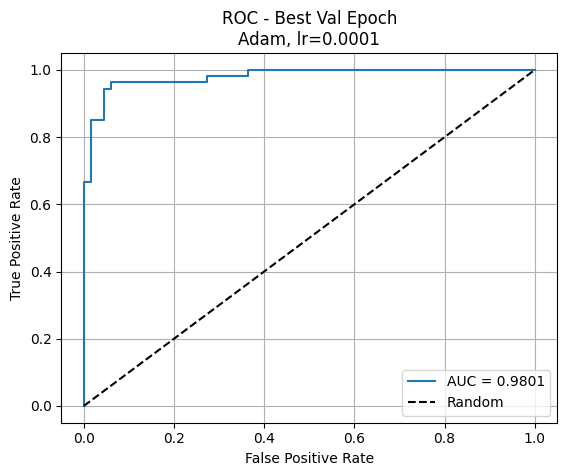

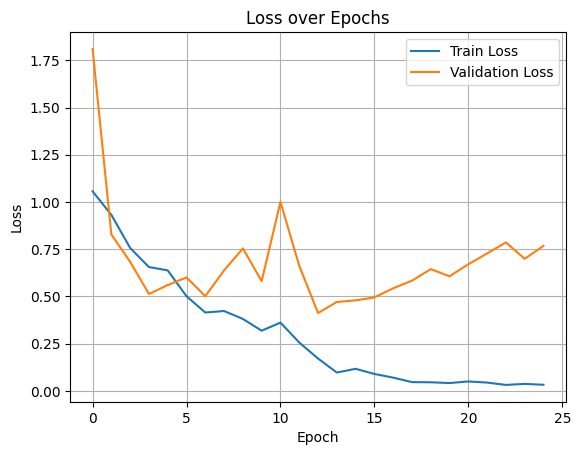

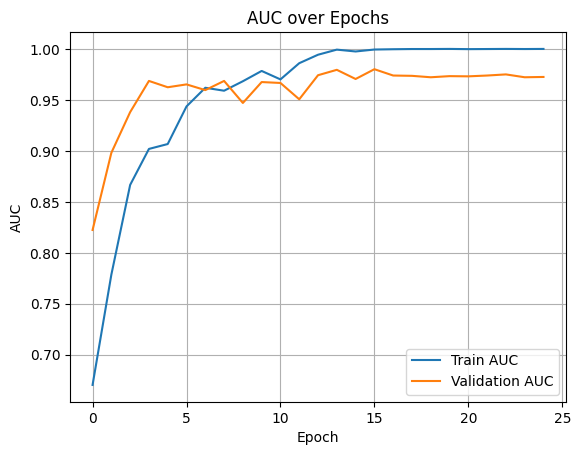

In [ ]:
from itertools import product

# for grid search, we run the Train loop with all Hyper-parameters below:
# learning_rates = [1e-4, 1e-5]
# optimizers_list = ['Adam', 'AdamW', 'SGD']

# then we selected the best parameters
learning_rates = [1e-4]
optimizers_list = ['Adam']

# all combinations of parameters
param_grid = list(product(learning_rates, optimizers_list))


# run the training loop

# note, not using parallel execution as the output can be mixed from several  when writing to csv
for lr, opt in param_grid:
    train_val(lr, opt)

Flushing unused memory and cache before proceeding to Test run:

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

# Test run

This is a final run, The model is laready trained and stored in the `pt` file. We read the file with modle parameters, and run the model to make predictions on the Unseen Test set.

The Unseen Test set hasn't been uesd for training or tuning at any point. This is the first time, the Test set is used after it has been held out in the very begining, before any model training.

In [ ]:
def evaluate_on_test(model, test_loader, criterion):
    model.eval()
    y_trues, y_preds, losses = [], [], []

    with torch.no_grad():
        for (sag_image, cor_image), label in test_loader:
            label = label.view(-1, 1).float()
            if torch.cuda.is_available():
                sag_image = sag_image.cuda()
                cor_image = cor_image.cuda()
                label = label.cuda()

            prediction = model(sag_image.float(), cor_image.float())
            loss = criterion(prediction, label)
            losses.append(loss.item())

            probas = torch.sigmoid(prediction)
            y_trues.extend(label.cpu().numpy().tolist())
            y_preds.extend(probas.cpu().numpy().tolist())

    y_true = np.array(y_trues)
    y_prob = np.array(y_preds)
    y_pred = (y_prob >= 0.5).astype(int)

    auc = metrics.roc_auc_score(y_true, y_prob)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn + 1e-6)
    specificity = tn / (tn + fp + 1e-6)

    return {
        'AUC': auc,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'y_true': y_true,
        'y_prob': y_prob
    }

# test data sets for sagittal and coronal planes

# as described earlier, we used pixel intesity normalization of the images.
# once the model is trained on normalized pixels, validation and test must supply into the model normalized images as well.
# pixel intensity normalization is the only data transformation we apply to our Validation or Test set

test_ds_sag = Dataset(
    root_dir=mrnet_directory,
    task=task,
    plane='sagittal',
    split='test',
    transform=validation_test_augmentor(mean_pixel_sag, std_pixel_sag),
    median_slices=median_slices_sag
)

test_ds_cor = Dataset(
    root_dir=mrnet_directory,
    task=task,
    plane='coronal',
    split='test',
    transform=validation_test_augmentor(mean_pixel_cor, std_pixel_cor),
    median_slices=median_slices_cor
)

# fused dataset
test_dataset = FusedPlanesDataset(test_ds_sag, test_ds_cor)

# data loader for test data set
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
    pin_memory=True
)

# loss funtion to use
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='mean')

Transform mean/std: 0.23093106274509806 0.19073743529411766
Transform mean/std: 0.2341083137254902 0.2517006980392157


Load the saved model, which we got from the best epoch during Training:

In [ ]:
# reload best model for test evaluation
model = TwoPlanesNet()

model.load_state_dict(torch.load(model_path))
model.eval()
if torch.cuda.is_available():
    model = model.cuda()

## Test run

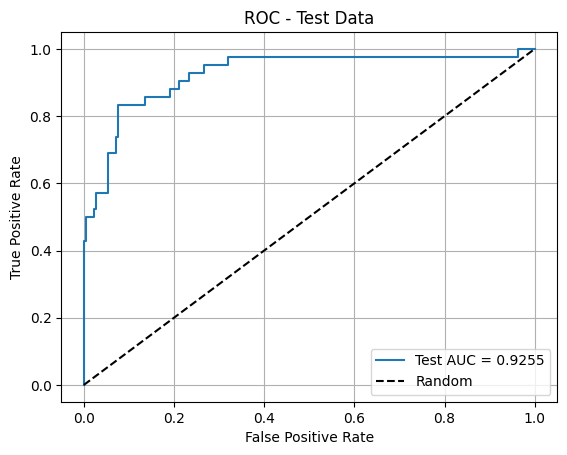

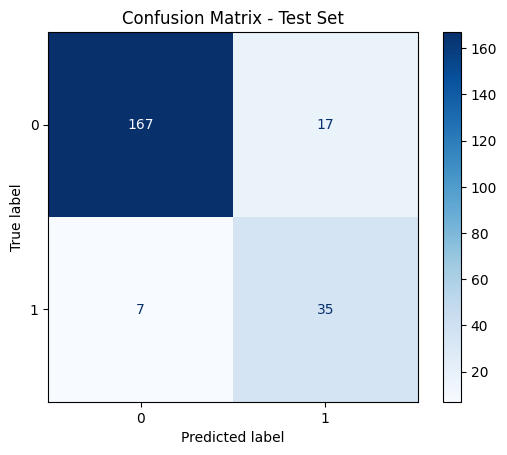

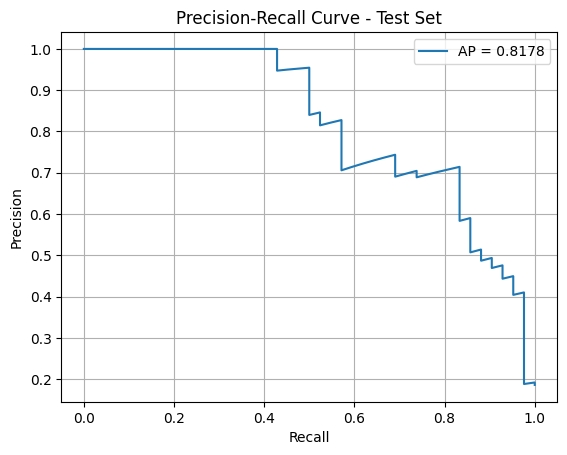

In [ ]:
# calls method to perorm predictions on the Test set
test_results = evaluate_on_test(model, test_loader, criterion)

# plot ROC for test run
fpr, tpr, _ = metrics.roc_curve(test_results['y_true'], test_results['y_prob'])

plt.figure()
plt.plot(fpr, tpr, label=f"Test AUC = {test_results['AUC']:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Test Data")
plt.legend()
plt.grid(True)

# save and show the ROC plot
plt.savefig(os.path.join(output_dir, f"roc_TEST.png"),
            dpi=300, bbox_inches='tight')
plt.show()

test_perf_file = os.path.join(output_dir, "performance_TEST.txt")
with open(test_perf_file, "w") as f:
    f.write(f"AUC         {test_results['AUC']:.4f}\n")
    f.write(f"Accuracy    {test_results['Accuracy']:.4f}\n")
    f.write(f"Sensitivity {test_results['Sensitivity']:.4f}\n")
    f.write(f"Specificity {test_results['Specificity']:.4f}\n")


# confusion matrix
cm = metrics.confusion_matrix(test_results['y_true'], (test_results['y_prob'] >= 0.5).astype(int))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.savefig(os.path.join(output_dir, "confusion_matrix_TEST.png"), dpi=300, bbox_inches='tight')
plt.show()


# Precision-Recall curve
precision, recall, _ = metrics.precision_recall_curve(test_results['y_true'], test_results['y_prob'])
ap_score = metrics.average_precision_score(test_results['y_true'], test_results['y_prob'])

plt.figure()
plt.plot(recall, precision, label=f"AP = {ap_score:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Test Set")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "pr_curve_TEST.png"), dpi=300, bbox_inches='tight')
plt.show()